In [2]:
from __future__ import annotations

import numpy as np
import sympy as sp

from randomness_contextuality_lp.contextuality import contextuality_robustness_to_dephasing
from randomness_contextuality_lp.quantum import (
    discover_operational_equivalences_from_gpt_objects,
    projector,
    projector_hs_vector,
    probability_table_from_gpt_vectors,
    contextuality_scenario_from_quantum,
)
from randomness_contextuality_lp.randomness import (
    eve_optimal_guessing_probability,
    min_entropy_bits,
    reverse_fano_bound,
)
from randomness_contextuality_lp.scenario import ContextualityScenario

In [3]:
def _xz_plane_ket(theta: sp.Expr | float | int) -> sp.Matrix:
    """Real-amplitude qubit ket with Bloch vector in the X-Z plane."""
    theta_sym = sp.sympify(theta)
    return sp.Matrix([sp.cos(theta_sym / 2), sp.sin(theta_sym / 2)])


def _normalize_integer_rays_symbolic(rays: np.ndarray) -> list[sp.Matrix]:
    """Normalize integer-valued ray rows exactly using SymPy."""
    ray_array = np.asarray(rays, dtype=int)
    if ray_array.ndim != 2:
        raise ValueError("rays must have shape (N, d).")

    normalized_kets: list[sp.Matrix] = []
    for row in ray_array:
        row_sym = [sp.Integer(int(entry)) for entry in row]
        norm_sq = sum(entry * entry for entry in row_sym)
        if norm_sq == 0:
            raise ValueError("Cannot normalize zero ray.")
        norm = sp.sqrt(norm_sq)
        normalized_kets.append(sp.Matrix([entry / norm for entry in row_sym]))
    return normalized_kets


def _print_title(title: str) -> None:
    print("\n" + "=" * 80)
    print(title)
    print("=" * 80)


def _print_manual_target_randomness(
    scenario: ContextualityScenario,
    measurement_indices: list[tuple[int, ...]],
    target_pair: tuple[int, int],
    bin_outcomes: list[list[int]] | tuple[tuple[int, ...], ...] | None = None,
) -> None:
    x_target, y_target = target_pair
    p_guess_eve = eve_optimal_guessing_probability(
        scenario,
        x=x_target,
        y=y_target,
        bin_outcomes=bin_outcomes,
    )
    p_guess_alice = scenario.alice_optimal_guessing_probability(
        x=x_target,
        y=y_target,
        bin_outcomes=bin_outcomes,
    )
    target_label = "Bob's outcome bins" if bin_outcomes is not None else "Bob's outcome"
    print(f"\nEve optimal guessing probability for {target_label} at target setting:")
    print(f"x_target={x_target}, y_target={y_target}")
    print(f"measurement indices={measurement_indices[y_target]}")
    if bin_outcomes is not None:
        print(f"bins={bin_outcomes}")
    print(f"P_guess = {p_guess_eve:.10f}")
    print(f"\nAlice optimal guessing probability for {target_label} at target setting:")
    print(f"x_target={x_target}, y_target={y_target}")
    if bin_outcomes is not None:
        print(f"bins={bin_outcomes}")
    print(f"P_guess = {p_guess_alice:.10f}")


def _print_manual_target_robustness(scenario: ContextualityScenario, example_label: str) -> None:
    robustness = contextuality_robustness_to_dephasing(scenario)
    print(f"\nContextuality robustness to dephasing ({example_label}):")
    print(f"r* = {robustness:.10f}")
    print("Interpretation: larger r* means more contextual (more dephasing needed to classicalize).")


def _print_measurement_index_sets(measurement_indices: list[tuple[int, ...]]) -> None:
    print("\nProvided measurement index sets (no inference):")
    for y, idx in enumerate(measurement_indices):
        print(f"y={y}: effects {idx}")

In [4]:
def _analyze_scenario(scenario: ContextualityScenario) -> tuple[np.ndarray, np.ndarray]:
    p_guess_eve_table = np.zeros((scenario.X_cardinality, scenario.Y_cardinality))
    fano_table = np.zeros((scenario.X_cardinality, scenario.Y_cardinality))
    keyrate_table = np.zeros((scenario.X_cardinality, scenario.Y_cardinality))
    alice_table = np.zeros((scenario.X_cardinality, scenario.Y_cardinality))

    for (x, y) in np.ndindex(scenario.X_cardinality, scenario.Y_cardinality):
        # Hacky
        p_guess_eve = eve_optimal_guessing_probability(scenario, x=x, y=y)
        if p_guess_eve > 1:
            p_guess_eve = 1
        if p_guess_eve < 0:
            raise ValueError(f"Invalid guessing probability: {p_guess_eve} at (x, y) = {(x, y)}")
        p_guess_eve_table[x, y] = p_guess_eve
        H_alice = scenario.conditional_entropy(x=x, y=y)
        alice_table[x, y] = H_alice
        fano = reverse_fano_bound(p_guess_eve)
        fano_table[x, y] = fano
        keyrate = fano - H_alice
        keyrate_table[x, y] = keyrate
    print()
    print(f"Eve's guessing probability (upper bound): {p_guess_eve_table.max()}")
    print(f"Eve's min-entropy in bits (lower bound): {min_entropy_bits(p_guess_eve_table.min())}")
    print(f"Eve's conditional Shannon entropy in bits (lower bound): {reverse_fano_bound(p_guess_eve_table.min())}")
    print(f"Maximal key rate in bits (lower bound): {keyrate_table.max()}")
    return p_guess_eve_table, fano_table, keyrate_table, alice_table

In [5]:
np.set_printoptions(precision=6, suppress=True)

ket0 = _xz_plane_ket(0)
ket1 = _xz_plane_ket(sp.pi)
ket_plus = _xz_plane_ket(sp.pi / 2)
ket_minus = _xz_plane_ket(-sp.pi / 2)

ket_pz_plus = _xz_plane_ket(sp.pi / 4)
ket_pz_minus = _xz_plane_ket(5 * sp.pi / 4)

ket_mz_plus = _xz_plane_ket(3 * sp.pi / 4)
ket_mz_minus = _xz_plane_ket(-sp.pi / 4)

quantum_states = np.array(
    [
        projector(ket0),
        projector(ket1),
        projector(ket_plus),
        projector(ket_minus),
    ],
    dtype=object,
)  # (X=4, d, d)

In [6]:
# Example 1: effects +/-Z, +/-X, +/- (X+Z).
effects_example_1 = np.array(
    [
        projector(ket0),       # +Z
        projector(ket1),       # -Z
        projector(ket_plus),   # +X
        projector(ket_minus),  # -X
        projector(ket_pz_plus),   # +(X+Z)
        projector(ket_pz_minus),  # -(X+Z)
    ],
    dtype=object,
)
_print_title("Example 1: Z, X, and (X+Z) measurements")
scenario_1 = contextuality_scenario_from_quantum(
    quantum_states=quantum_states,
    quantum_effect_set=effects_example_1,
    outcomes_per_measurement=2,
    verbose=False,
)
probs_1, fano_1, keyrates_1, alice_1 = _analyze_scenario(scenario_1)
_print_manual_target_robustness(scenario_1, "Example 1")


Example 1: Z, X, and (X+Z) measurements

Eve's guessing probability (upper bound): 1.0
Eve's min-entropy in bits (lower bound): 0.33480150772378825
Eve's conditional Shannon entropy in bits (lower bound): 0.41421356237309537
Maximal key rate in bits (lower bound): 2.220446049250313e-16

Contextuality robustness to dephasing (Example 1):
r* = 0.1715728752
Interpretation: larger r* means more contextual (more dephasing needed to classicalize).


In [7]:
# Example 2: effects +/- (X+Z), +/- (X-Z).
effects_example_2 = np.array(
    [
        projector(ket_pz_plus),   # +(X+Z)
        projector(ket_pz_minus),  # -(X+Z)
        projector(ket_mz_plus),   # +(X-Z)
        projector(ket_mz_minus),  # -(X-Z)
    ],
    dtype=object,
)
_print_title("Example 2: (X+Z) and (X-Z) measurements")
scenario_2 = contextuality_scenario_from_quantum(
    quantum_states=quantum_states,
    quantum_effect_set=effects_example_2,
    outcomes_per_measurement=2,
    verbose=False,
)
probs_2, fano_2, keyrates_2, alice_2 = _analyze_scenario(scenario_2)
_print_manual_target_robustness(scenario_2, "Example 2")


Example 2: (X+Z) and (X-Z) measurements

Eve's guessing probability (upper bound): 1.0
Eve's min-entropy in bits (lower bound): -0.0
Eve's conditional Shannon entropy in bits (lower bound): 0.0
Maximal key rate in bits (lower bound): -0.6008760366928562

Contextuality robustness to dephasing (Example 2):
r* = 0.2928932185
Interpretation: larger r* means more contextual (more dephasing needed to classicalize).


In [8]:
# Example 3: 6 hexagon preparations/effects in the X-Z plane.
# Preparations are grouped into 3 settings of 2 outcomes (|A|=2).
thetas = [sp.Integer(k) * sp.pi / 3 for k in range(6)]
hex_kets = [_xz_plane_ket(theta) for theta in thetas]

# Pair opposite vertices so each preparation setting averages to maximally mixed.
prep_pairs = [(0, 3), (1, 4), (2, 5)]
measurement_indices_3 = [(0, 3), (1, 4), (2, 5)]
gpt_states_3 = np.array(
    [
        [projector_hs_vector(hex_kets[i]), projector_hs_vector(hex_kets[j])]
        for (i, j) in prep_pairs
    ],
    dtype=object,
)
gpt_effects_3 = np.array(
    [
        [projector_hs_vector(hex_kets[i]), projector_hs_vector(hex_kets[j])]
        for (i, j) in measurement_indices_3
    ],
    dtype=object,
)
opeq_preps_3 = discover_operational_equivalences_from_gpt_objects(gpt_states_3)
opeq_meas_3 = discover_operational_equivalences_from_gpt_objects(gpt_effects_3)
data_3 = probability_table_from_gpt_vectors(gpt_states_3, gpt_effects_3)
_print_title("Example 3: Hexagon states/effects in X-Z plane (|A|=2)")
scenario_3 = ContextualityScenario(
    data=np.real_if_close(data_3).astype(float),
    opeq_preps=np.real_if_close(opeq_preps_3).astype(float),
    opeq_meas=np.real_if_close(opeq_meas_3).astype(float),
    verbose=False,
)
_print_measurement_index_sets(measurement_indices_3)
probs_3, fano_3, keyrates_3, alice_3 = _analyze_scenario(scenario_3)
_print_manual_target_robustness(scenario_3, "Example 3")


Example 3: Hexagon states/effects in X-Z plane (|A|=2)

Provided measurement index sets (no inference):
y=0: effects (0, 3)
y=1: effects (1, 4)
y=2: effects (2, 5)

Eve's guessing probability (upper bound): 0.7500000000000002
Eve's min-entropy in bits (lower bound): 0.41503749927884404
Eve's conditional Shannon entropy in bits (lower bound): 0.5000000000000002
Maximal key rate in bits (lower bound): 0.5

Contextuality robustness to dephasing (Example 3):
r* = 0.3333333333
Interpretation: larger r* means more contextual (more dephasing needed to classicalize).


In [9]:
# Example 4: Cabello-style 18-ray KS set in d=4, using GPT constructor directly.
# 9 measurements, each with 4 outcomes; each effect appears in multiple measurements.
labels = list("123456789ABCDEFGHI")
cabello_rays = np.array(
    [
        [1, 0, 0, 0],   # 1
        [0, 1, 0, 0],   # 2
        [0, 0, 1, 0],   # 3
        [1, 1, 1, 1],   # 4
        [1, -1, 1, -1], # 5
        [1, -1, -1, 1], # 6
        [1, -1, -1, -1],# 7
        [1, -1, 1, 1],  # 8
        [1, 1, 1, -1],  # 9
        [1, 1, 0, 0],   # A
        [0, 0, 1, 1],   # B
        [0, 0, 1, -1],  # C
        [0, 1, 0, 1],   # D
        [0, 1, 0, -1],  # E
        [1, 0, -1, 0],  # F
        [1, 0, 0, -1],  # G
        [1, 0, 0, 1],   # H
        [0, 1, -1, 0],  # I
    ],
    dtype=int,
)
cabello_kets = _normalize_integer_rays_symbolic(cabello_rays)
label_to_index = {lab: i for i, lab in enumerate(labels)}

contexts = [
    "12BC",
    "13DE",
    "23GH",
    "45EF",
    "46GI",
    "56AB",
    "78AC",
    "79HI",
    "89DF",
]
context_indices_4 = [tuple(label_to_index[ch] for ch in context) for context in contexts]

gpt_effect_set_example_4 = np.array([projector_hs_vector(ket) for ket in cabello_kets], dtype=object)
gpt_effects_grouped_example_4 = np.array(
    [[gpt_effect_set_example_4[idx] for idx in context] for context in context_indices_4],
    dtype=object,
)  # (Y=9, B=4, K)
gpt_states_example_4 = np.array(
    [[projector_hs_vector(cabello_kets[idx]) for idx in context] for context in context_indices_4],
    dtype=object,
)
opeq_preps_4 = discover_operational_equivalences_from_gpt_objects(gpt_states_example_4)
opeq_meas_4 = discover_operational_equivalences_from_gpt_objects(gpt_effects_grouped_example_4)
data_4 = probability_table_from_gpt_vectors(gpt_states_example_4, gpt_effects_grouped_example_4)
_print_title("Example 4: Cabello 18-ray KS set via GPT constructor (9 x 4 contexts)")
scenario_4 = ContextualityScenario(
    data=np.real_if_close(data_4).astype(float),
    opeq_preps=np.real_if_close(opeq_preps_4).astype(float),
    opeq_meas=np.real_if_close(opeq_meas_4).astype(float),
    verbose=False,
)
print(scenario_4)
# print("\nData table P(a,b|x,y):")
# scenario_4.print_probabilities(as_p_b_given_x_y=False)
_print_measurement_index_sets(context_indices_4)
probs_4, fano_4, keyrates_4, alice_4 = _analyze_scenario(scenario_4)
_print_manual_target_robustness(scenario_4, "Example 4")


Example 4: Cabello 18-ray KS set via GPT constructor (9 x 4 contexts)
ContextualityScenario(X=9, Y=9, A=4, B=4, num_opeq_preps=26, num_opeq_meas=26)

Provided measurement index sets (no inference):
y=0: effects (0, 1, 10, 11)
y=1: effects (0, 2, 12, 13)
y=2: effects (1, 2, 15, 16)
y=3: effects (3, 4, 13, 14)
y=4: effects (3, 5, 15, 17)
y=5: effects (4, 5, 9, 10)
y=6: effects (6, 7, 9, 11)
y=7: effects (6, 8, 16, 17)
y=8: effects (7, 8, 12, 14)

Eve's guessing probability (upper bound): 0.6250000000000013
Eve's min-entropy in bits (lower bound): 0.6780719051126415
Eve's conditional Shannon entropy in bits (lower bound): 0.7500000000000033
Maximal key rate in bits (lower bound): 0.7500000000000011

Contextuality robustness to dephasing (Example 4):
r* = 0.3333330166
Interpretation: larger r* means more contextual (more dephasing needed to classicalize).


In [10]:
# Example 5: Peres 24-ray construction restricted to 6 disjoint bases.
# Grouping is by contiguous 4-ray blocks from the screenshot:
# {1,2,3,4}, {5,6,7,8}, ..., {21,22,23,24}.

# Peres 24 rays from the screenshot (barred digit -> negative entry).
peres_rays = np.array(
    [
        [2, 0, 0, 0],   # 1
        [0, 2, 0, 0],   # 2
        [0, 0, 2, 0],   # 3
        [0, 0, 0, 2],   # 4
        [1, 1, 1, 1],   # 5
        [1, 1, -1, -1], # 6
        [1, -1, 1, -1], # 7
        [1, -1, -1, 1], # 8
        [1, -1, -1, -1],# 9
        [1, -1, 1, 1],  # 10
        [1, 1, -1, 1],  # 11
        [1, 1, 1, -1],  # 12
        [1, 1, 0, 0],   # 13
        [1, -1, 0, 0],  # 14
        [0, 0, 1, 1],   # 15
        [0, 0, 1, -1],  # 16
        [0, 1, 0, 1],   # 17
        [0, 1, 0, -1],  # 18
        [1, 0, 1, 0],   # 19
        [1, 0, -1, 0],  # 20
        [1, 0, 0, -1],  # 21
        [1, 0, 0, 1],   # 22
        [0, 1, -1, 0],  # 23
        [0, 1, 1, 0],   # 24
    ],
    dtype=int,
)
peres_kets = _normalize_integer_rays_symbolic(peres_rays)

context_indices_5 = [tuple(range(4 * y, 4 * (y + 1))) for y in range(6)]
gpt_effect_set_example_5 = np.array([projector_hs_vector(ket) for ket in peres_kets], dtype=object)
gpt_effects_grouped_example_5 = np.array(
    [[gpt_effect_set_example_5[idx] for idx in context] for context in context_indices_5],
    dtype=object,
)  # (6, 4, K)
gpt_states_example_5 = np.array(gpt_effects_grouped_example_5, copy=True)

opeq_preps_5 = discover_operational_equivalences_from_gpt_objects(gpt_states_example_5)
opeq_meas_5 = discover_operational_equivalences_from_gpt_objects(gpt_effects_grouped_example_5)
data_5 = probability_table_from_gpt_vectors(gpt_states_example_5, gpt_effects_grouped_example_5)

_print_title("Example 5: Peres 24 rays in 6 disjoint 4-ray bases")
scenario_5 = ContextualityScenario(
    data=np.real_if_close(data_5).astype(float),
    opeq_preps=np.real_if_close(opeq_preps_5).astype(float),
    opeq_meas=np.real_if_close(opeq_meas_5).astype(float),
    verbose=False,
)
print(scenario_5)
_print_measurement_index_sets(context_indices_5)
probs_5, fano_5, keyrates_5, alice_5 = _analyze_scenario(scenario_5)
_print_manual_target_robustness(scenario_5, "Example 5")


Example 5: Peres 24 rays in 6 disjoint 4-ray bases
ContextualityScenario(X=6, Y=6, A=4, B=4, num_opeq_preps=14, num_opeq_meas=14)

Provided measurement index sets (no inference):
y=0: effects (0, 1, 2, 3)
y=1: effects (4, 5, 6, 7)
y=2: effects (8, 9, 10, 11)
y=3: effects (12, 13, 14, 15)
y=4: effects (16, 17, 18, 19)
y=5: effects (20, 21, 22, 23)

Eve's guessing probability (upper bound): 0.5000000000000063
Eve's min-entropy in bits (lower bound): 1.0000000000000528
Eve's conditional Shannon entropy in bits (lower bound): 1.0000000000000642
Maximal key rate in bits (lower bound): 1.0000000000000642

Contextuality robustness to dephasing (Example 5):
r* = 0.4444441675
Interpretation: larger r* means more contextual (more dephasing needed to classicalize).


In [11]:
probs = [probs_1, probs_2, probs_3, probs_4, probs_5]
fanos = [fano_1, fano_2, fano_3, fano_4, fano_5]
keyrates = [keyrates_1, keyrates_2, keyrates_3, keyrates_4, keyrates_5]
alices = [alice_1, alice_2, alice_3, alice_4, alice_5]

In [12]:
from matplotlib import pyplot as plt

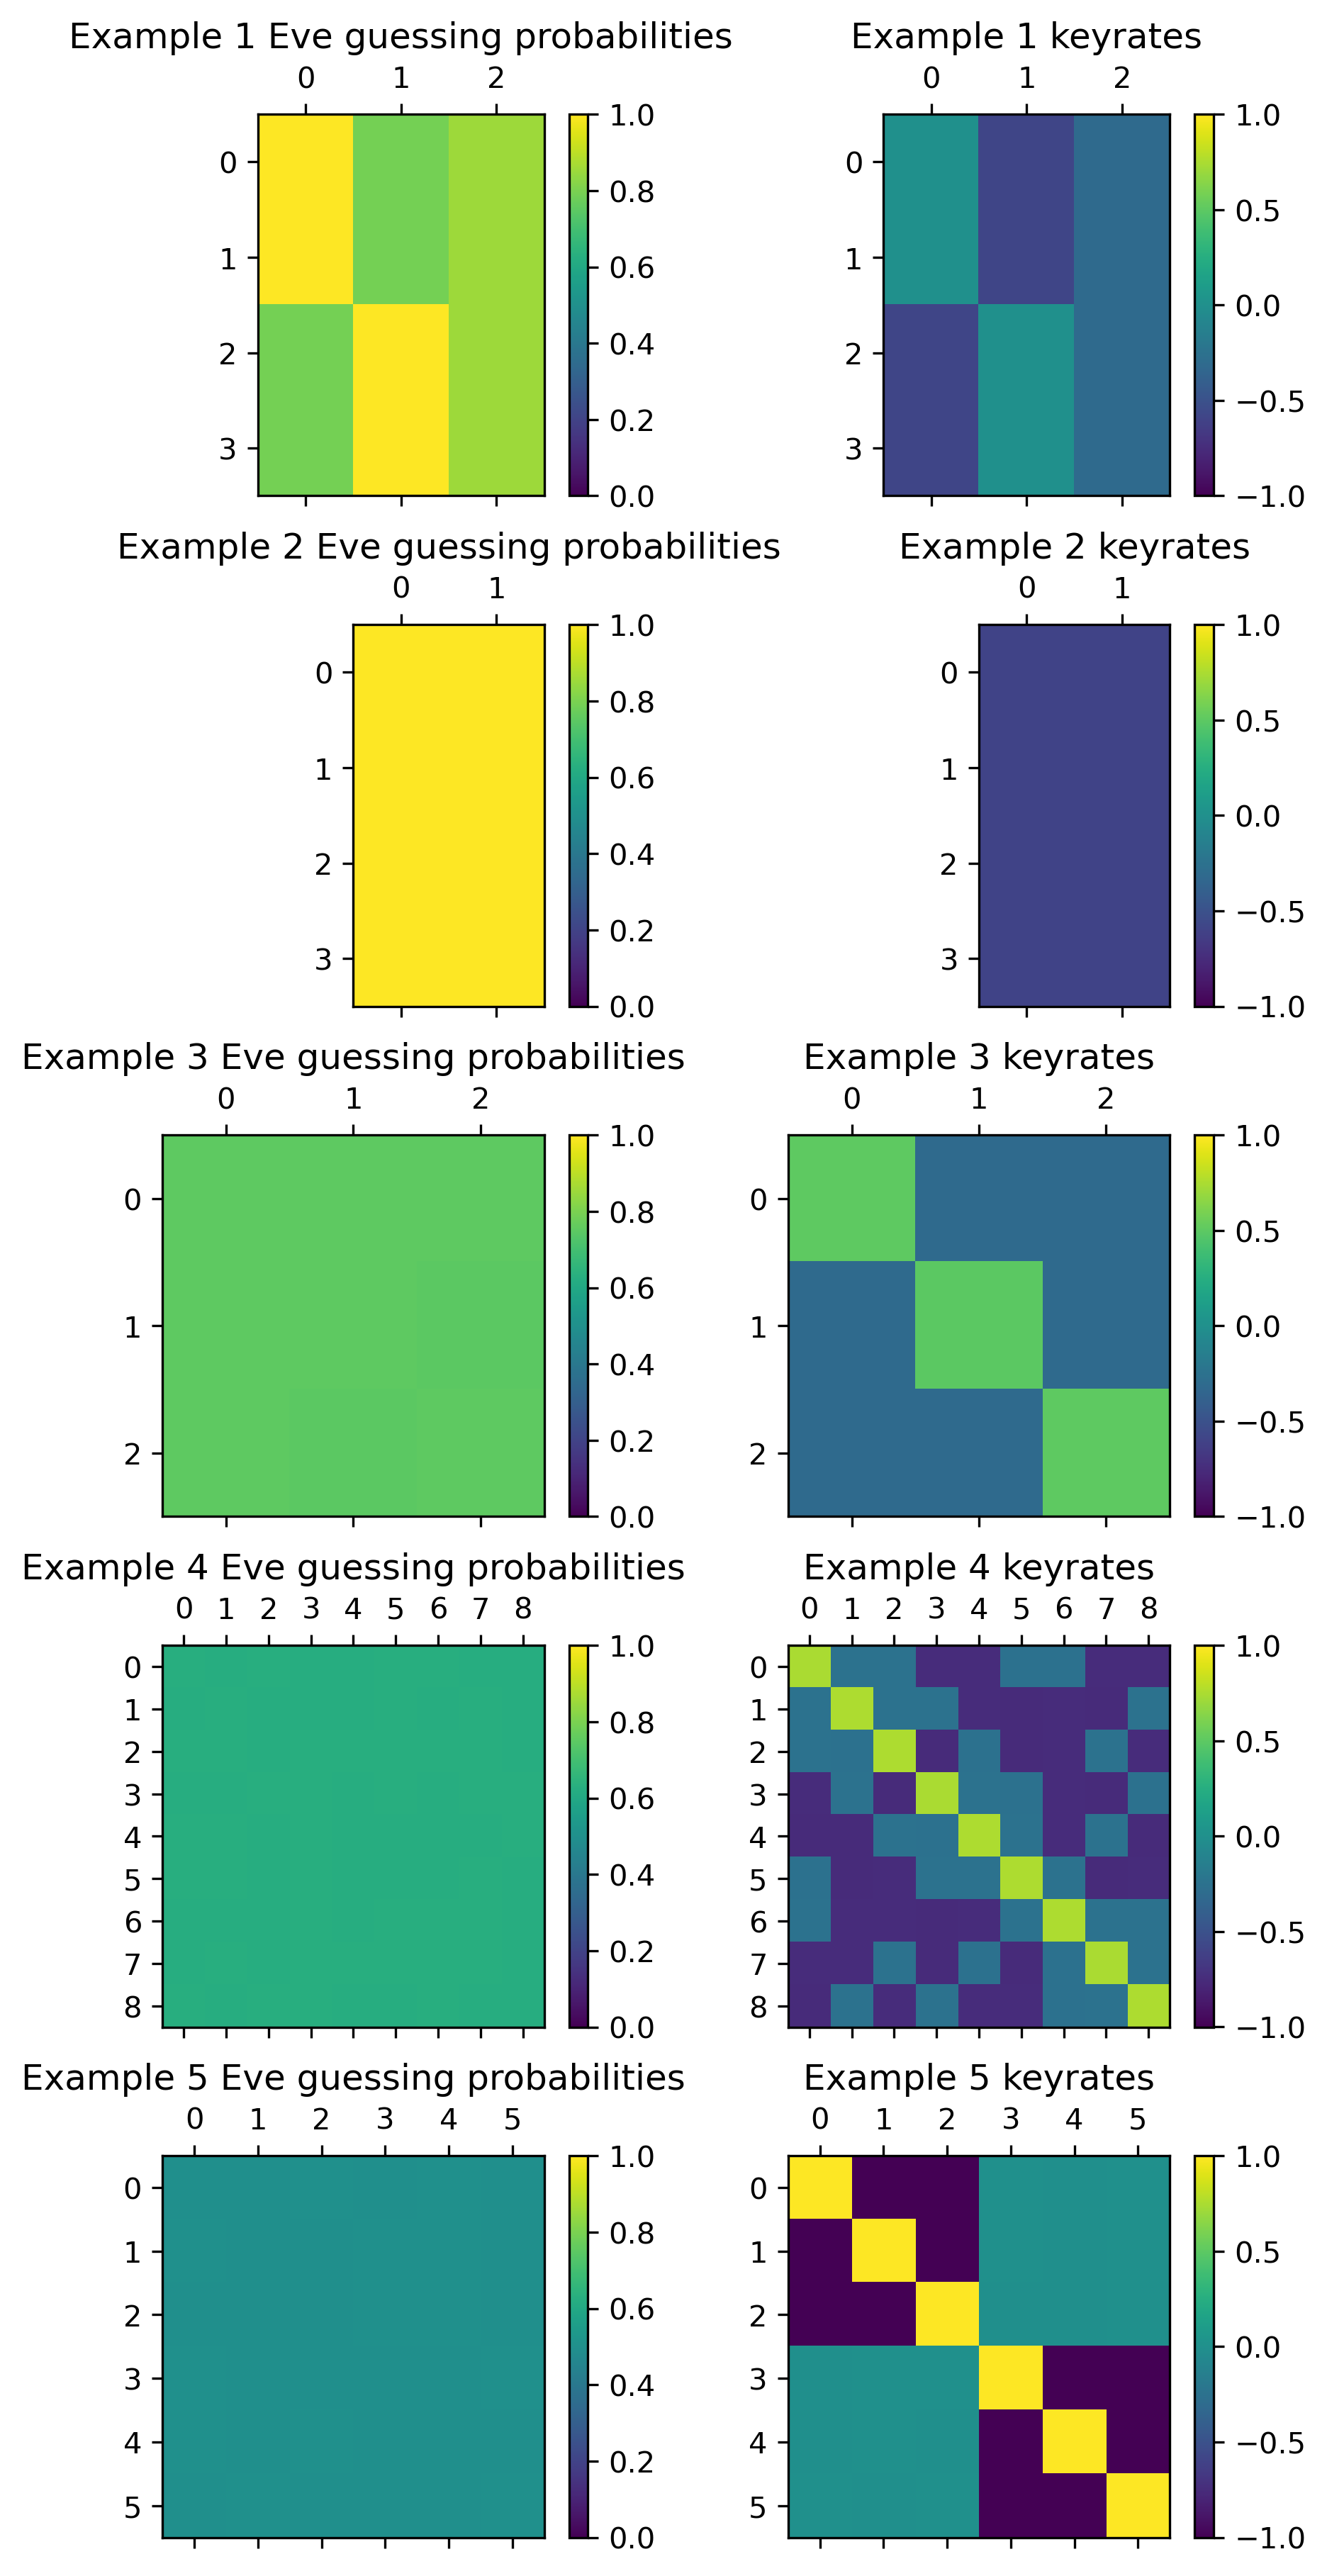

In [13]:
fig, ax = plt.subplots(5, 2, figsize = (6, 12), dpi = 300, layout = "constrained")
for i in range(5):
    pos = ax[i, 0].matshow(probs[i], vmin = 0, vmax = 1)
    fig.colorbar(pos, ax = ax[i, 0])
    ax[i, 0].set_title(f"Example {i+1} Eve guessing probabilities")
    pos = ax[i, 1].matshow(keyrates[i], vmin = -1, vmax = 1)
    fig.colorbar(pos, ax = ax[i, 1])
    ax[i, 1].set_title(f"Example {i+1} keyrates")
plt.savefig("plots/dan_demo.png")

In [14]:
def makeplot(id = 0):
    fig, ax = plt.subplots(2, 2, figsize = (10, 10), dpi = 300, layout = "constrained")

    pos = ax[0, 0].matshow(probs[id].T, vmin = 0, vmax = 1)
    for (i, j), z in np.ndenumerate(probs[id]):
        ax[0, 0].text(i, j, f"{z:.2f}", ha="center", va="center")
    fig.colorbar(pos, ax = ax[0, 0])
    ax[0, 0].set_title("Eve's optimal guessing probabilities")
    ax[0, 0].set_xlabel(r"$X^*$")
    ax[0, 0].set_ylabel(r"$Y^*$")

    pos = ax[0, 1].matshow(keyrates[id].T, vmin = -1, vmax = 1)
    for (i, j), z in np.ndenumerate(keyrates[id]):
        ax[0, 1].text(i, j, f"{z:.2f}", ha="center", va="center")
    fig.colorbar(pos, ax = ax[0, 1])
    ax[0, 1].set_title("Key rates, lower bound")
    ax[0, 1].set_xlabel(r"$X^*$")
    ax[0, 1].set_ylabel(r"$Y^*$")

    pos = ax[1, 0].matshow(alices[id].T, vmin = 0, vmax = 2)
    for (i, j), z in np.ndenumerate(alices[id]):
        ax[1, 0].text(i, j, f"{z:.2f}", ha="center", va="center")
    fig.colorbar(pos, ax = ax[1, 0])
    ax[1, 0].set_title(r"$H(B\mid A,X^*,Y^*)$")
    ax[1, 0].set_xlabel(r"$X^*$")
    ax[1, 0].set_ylabel(r"$Y^*$")

    pos = ax[1, 1].matshow(fanos[id].T, vmin = 0, vmax = 1)
    for (i, j), z in np.ndenumerate(fanos[id]):
        ax[1, 1].text(i, j, f"{z:.2f}", ha="center", va="center")
    fig.colorbar(pos, ax = ax[1, 1])
    ax[1, 1].set_title(r"$H(B\mid E,X^*,Y^*)$, lower bound")
    ax[1, 1].set_xlabel(r"$X^*$")
    ax[1, 1].set_ylabel(r"$Y^*$")

    # fig.suptitle(f"Example {id+1}")

    plt.savefig(f"plots/dan_demo_{id}.png")

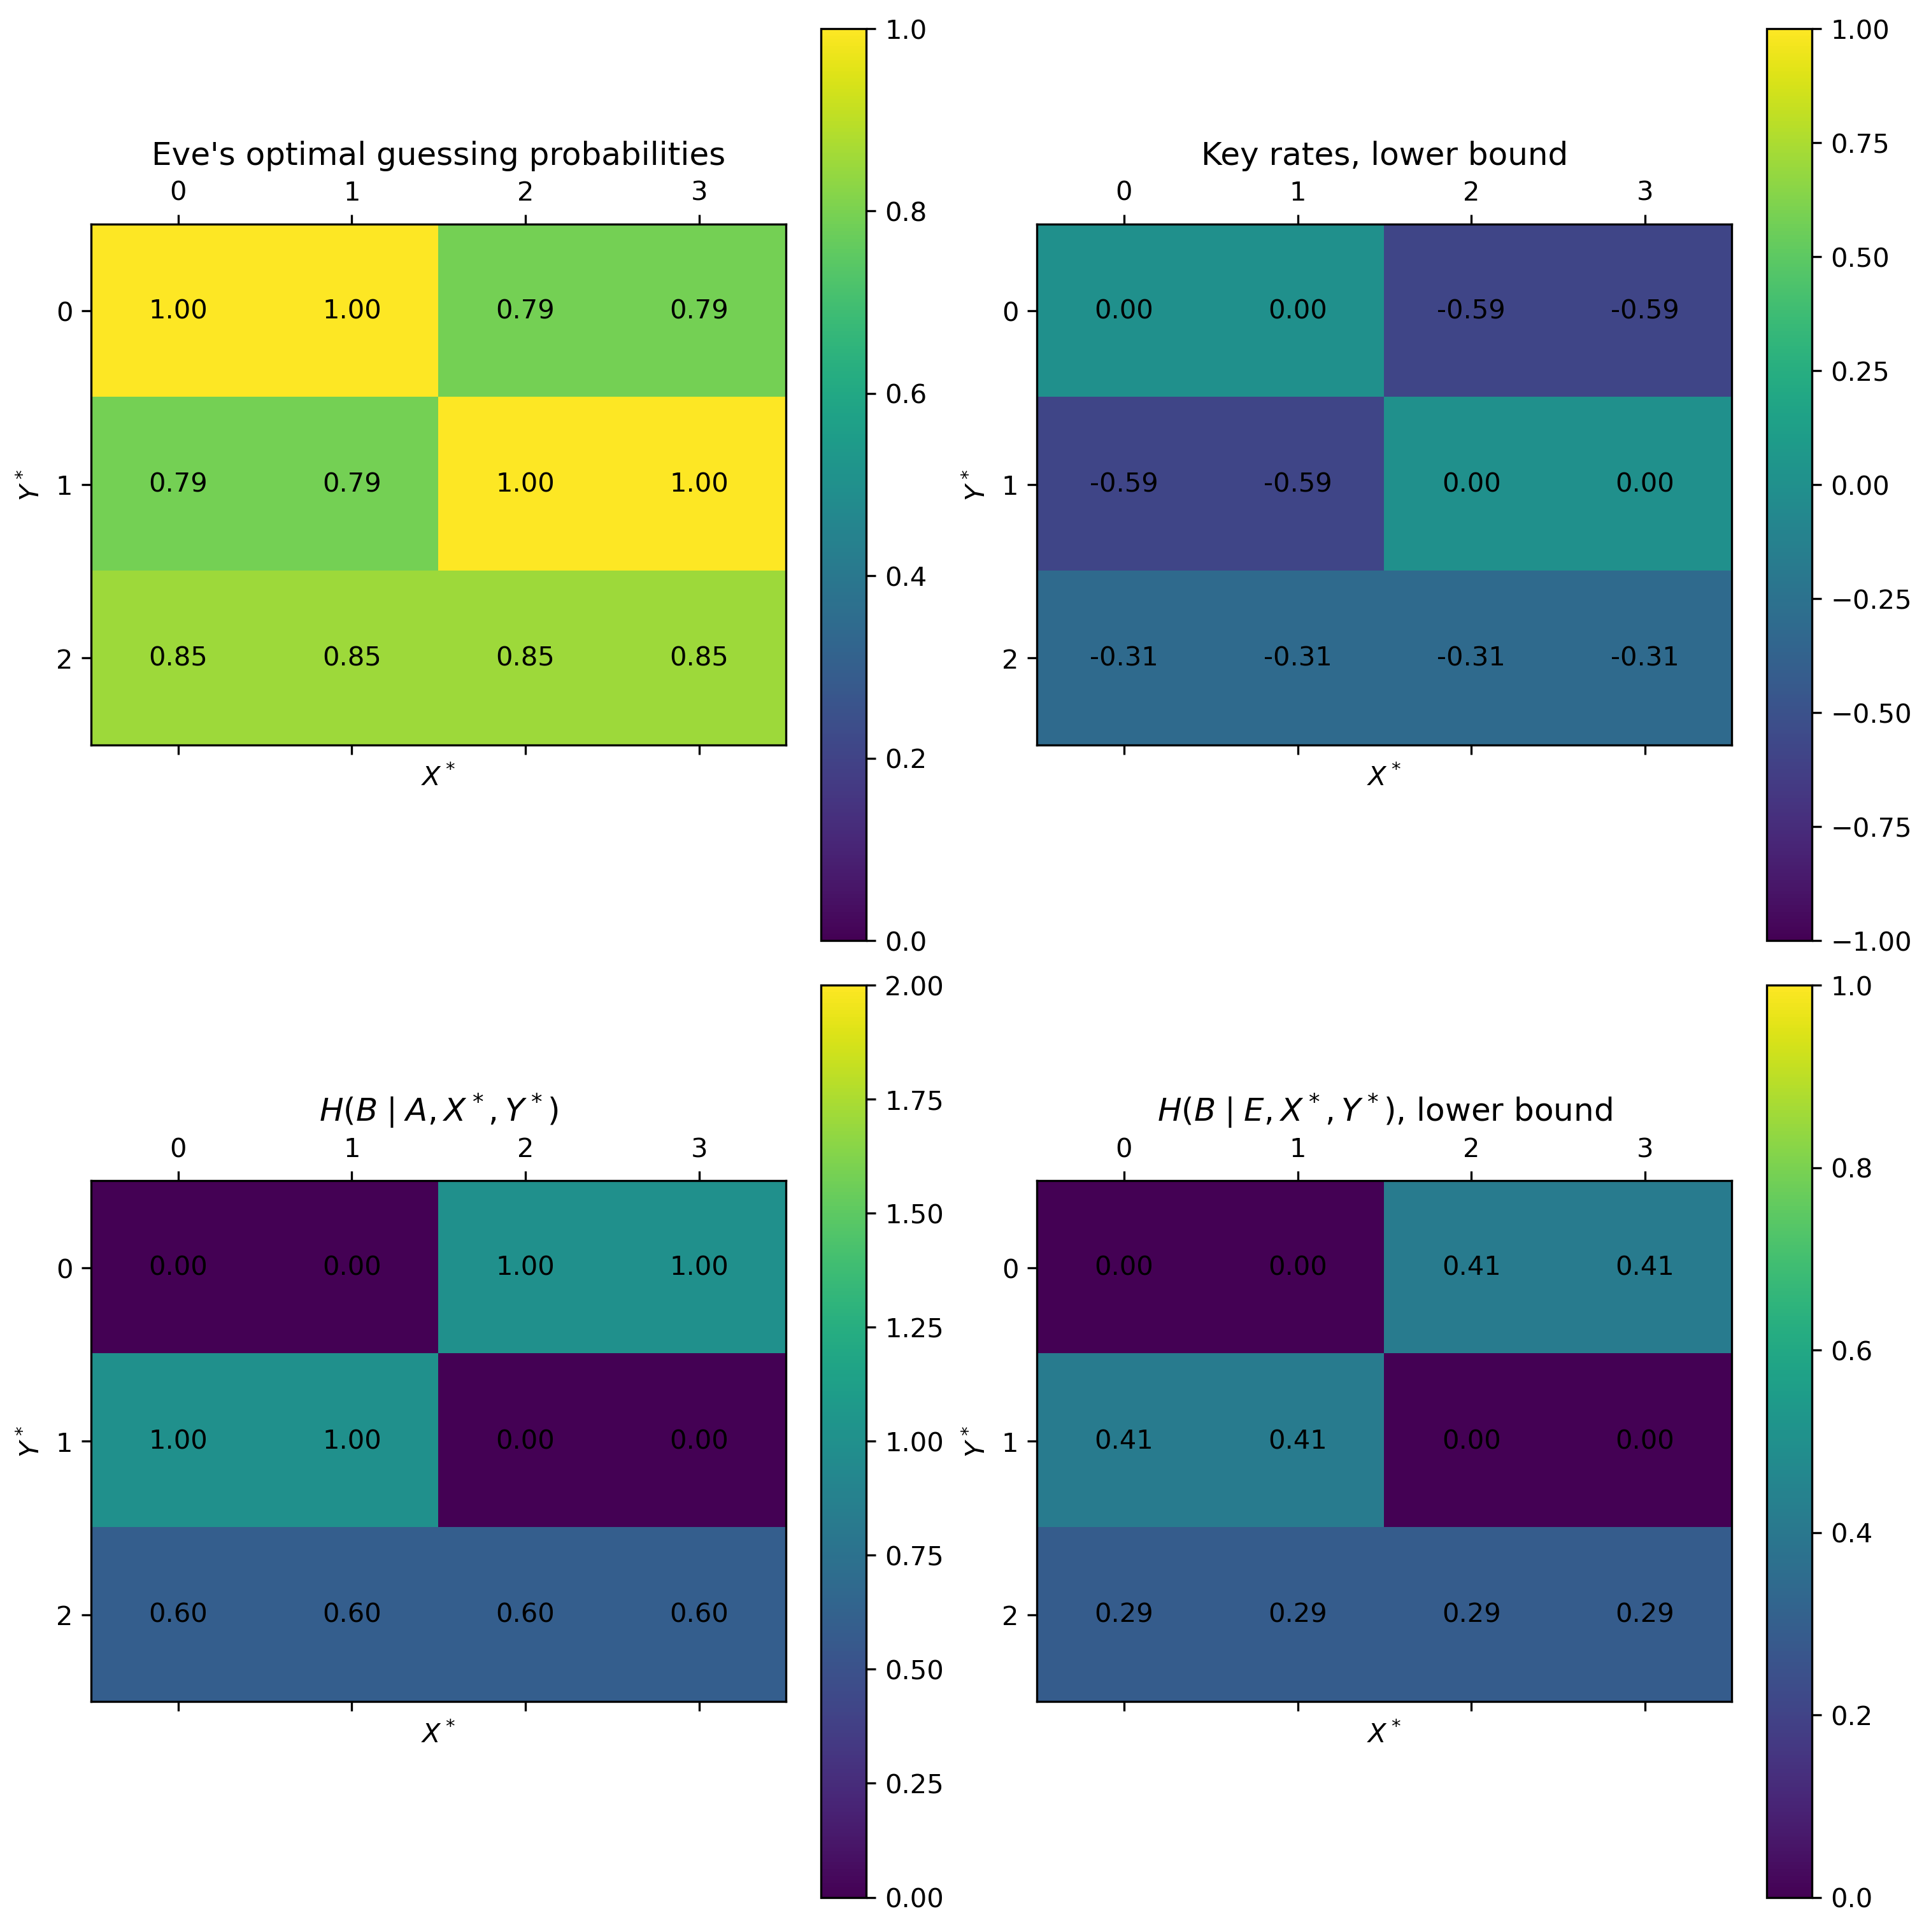

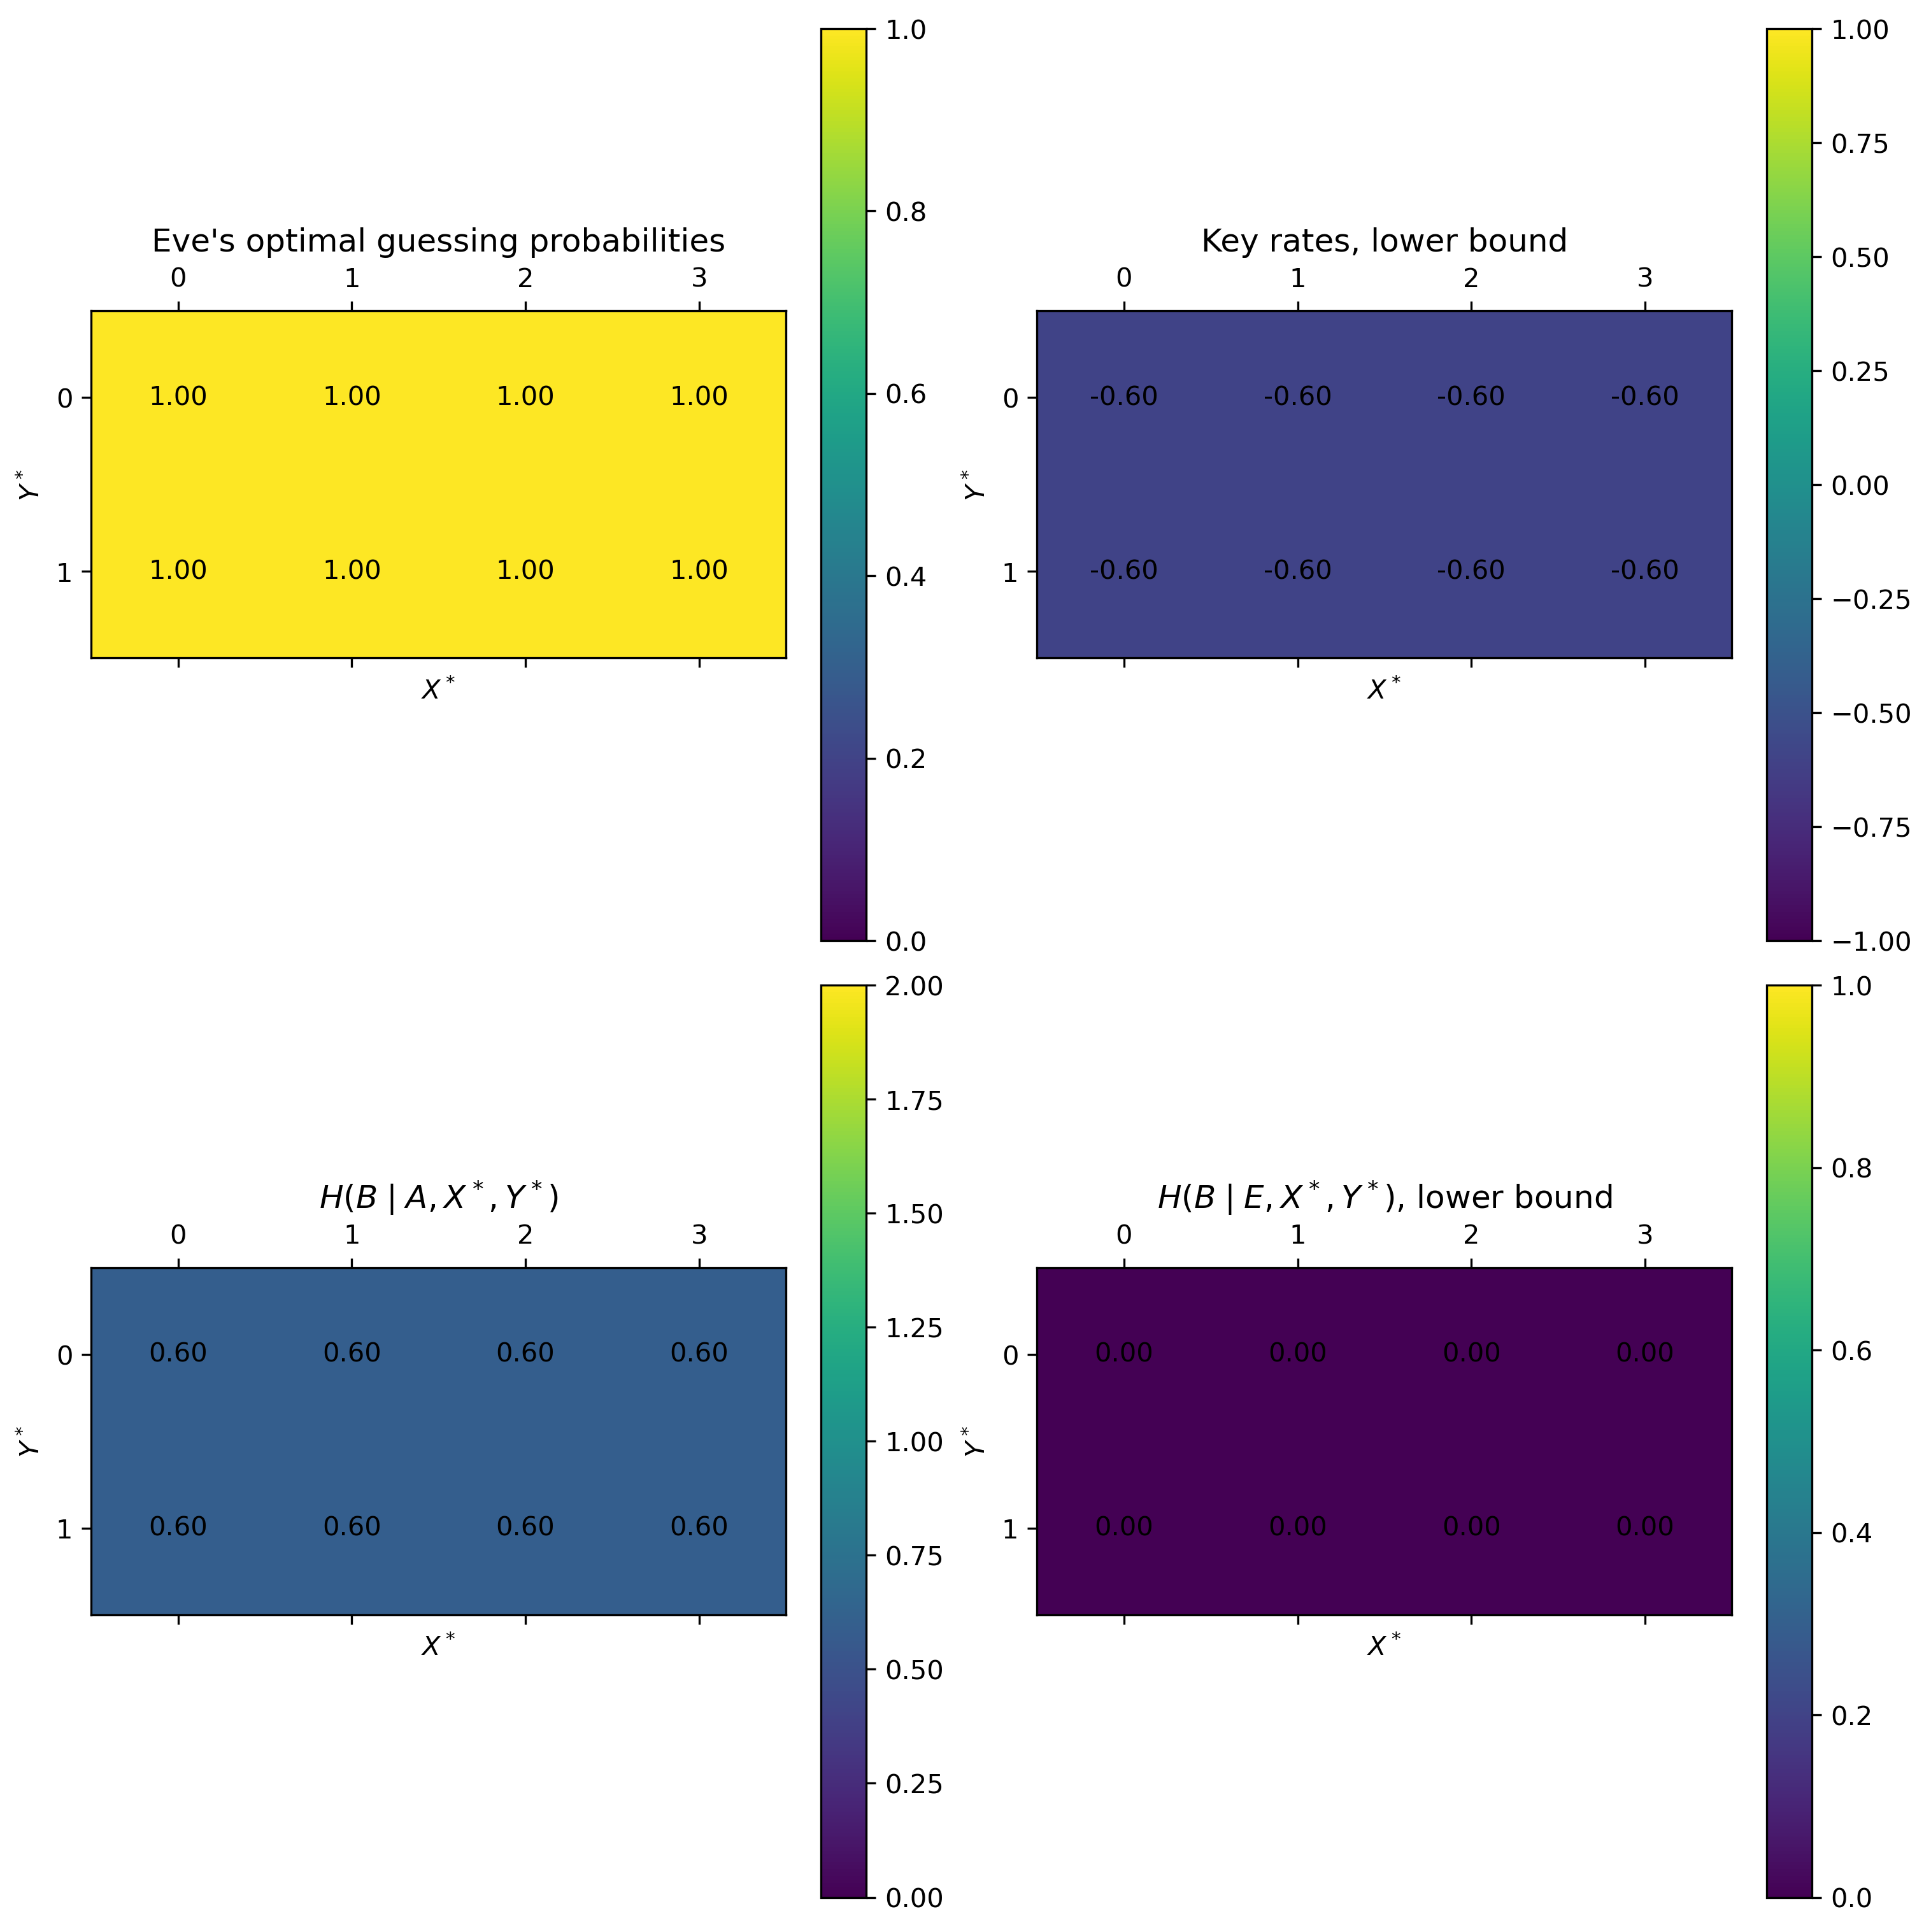

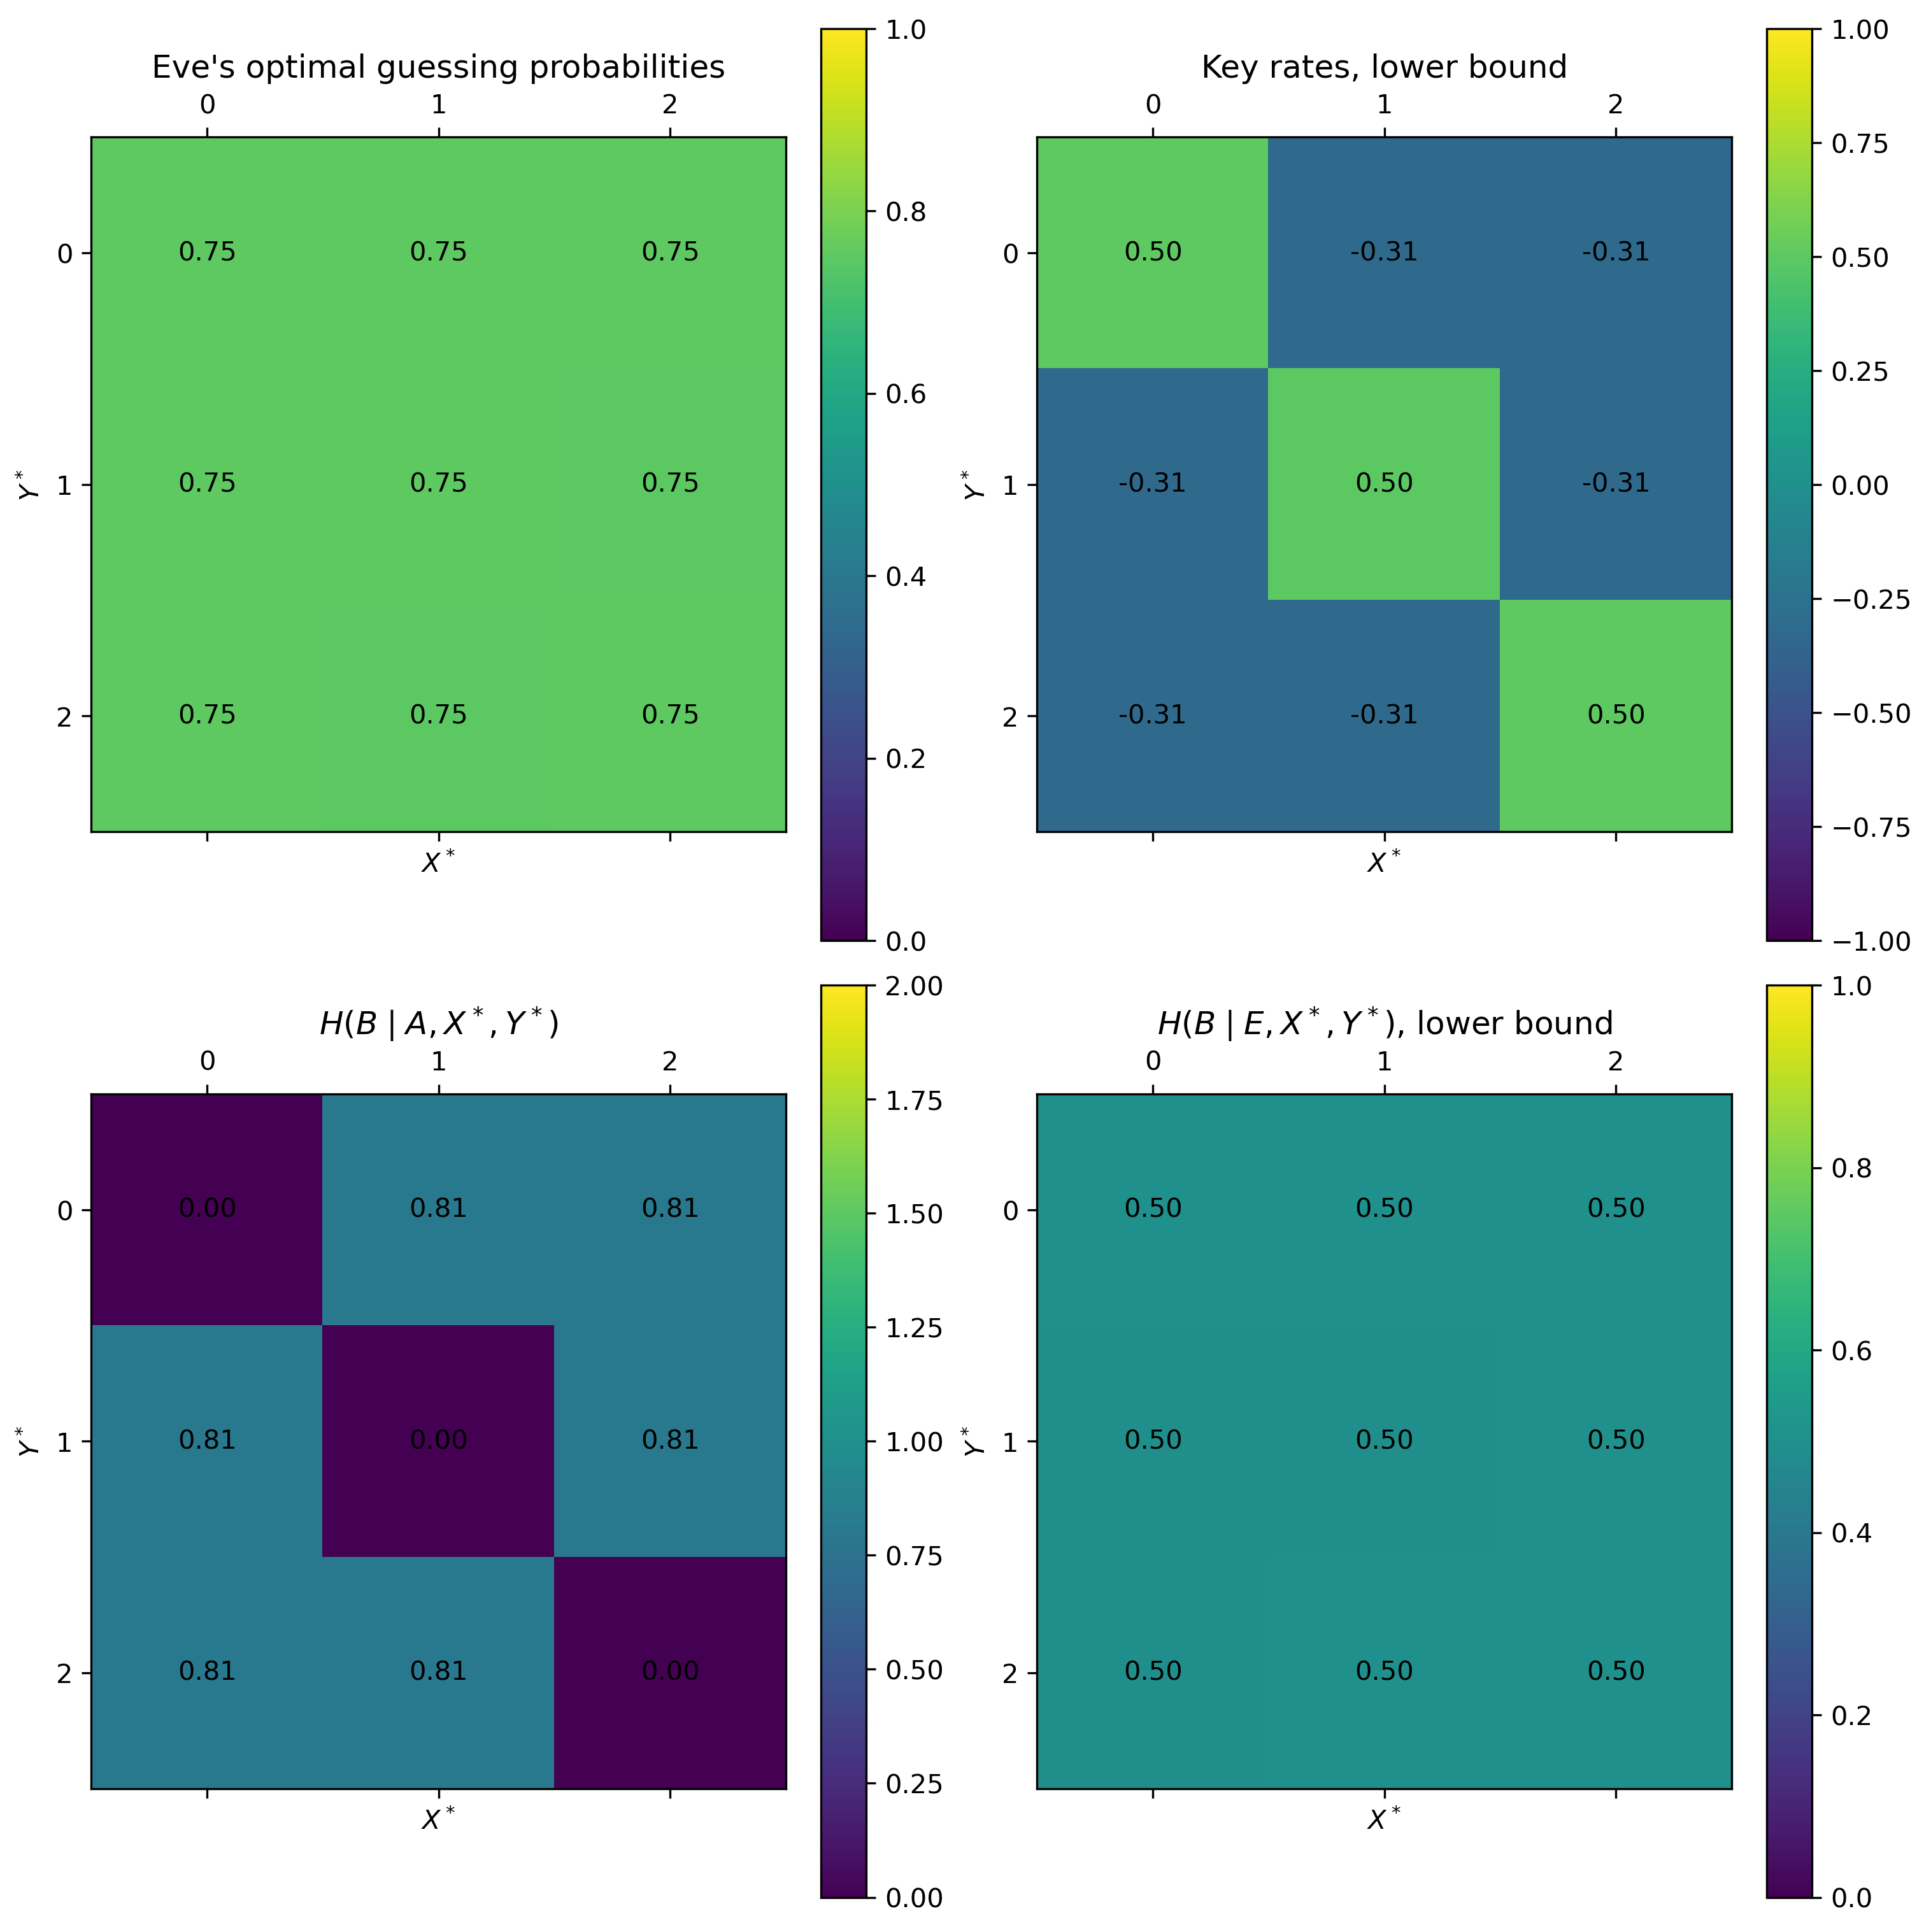

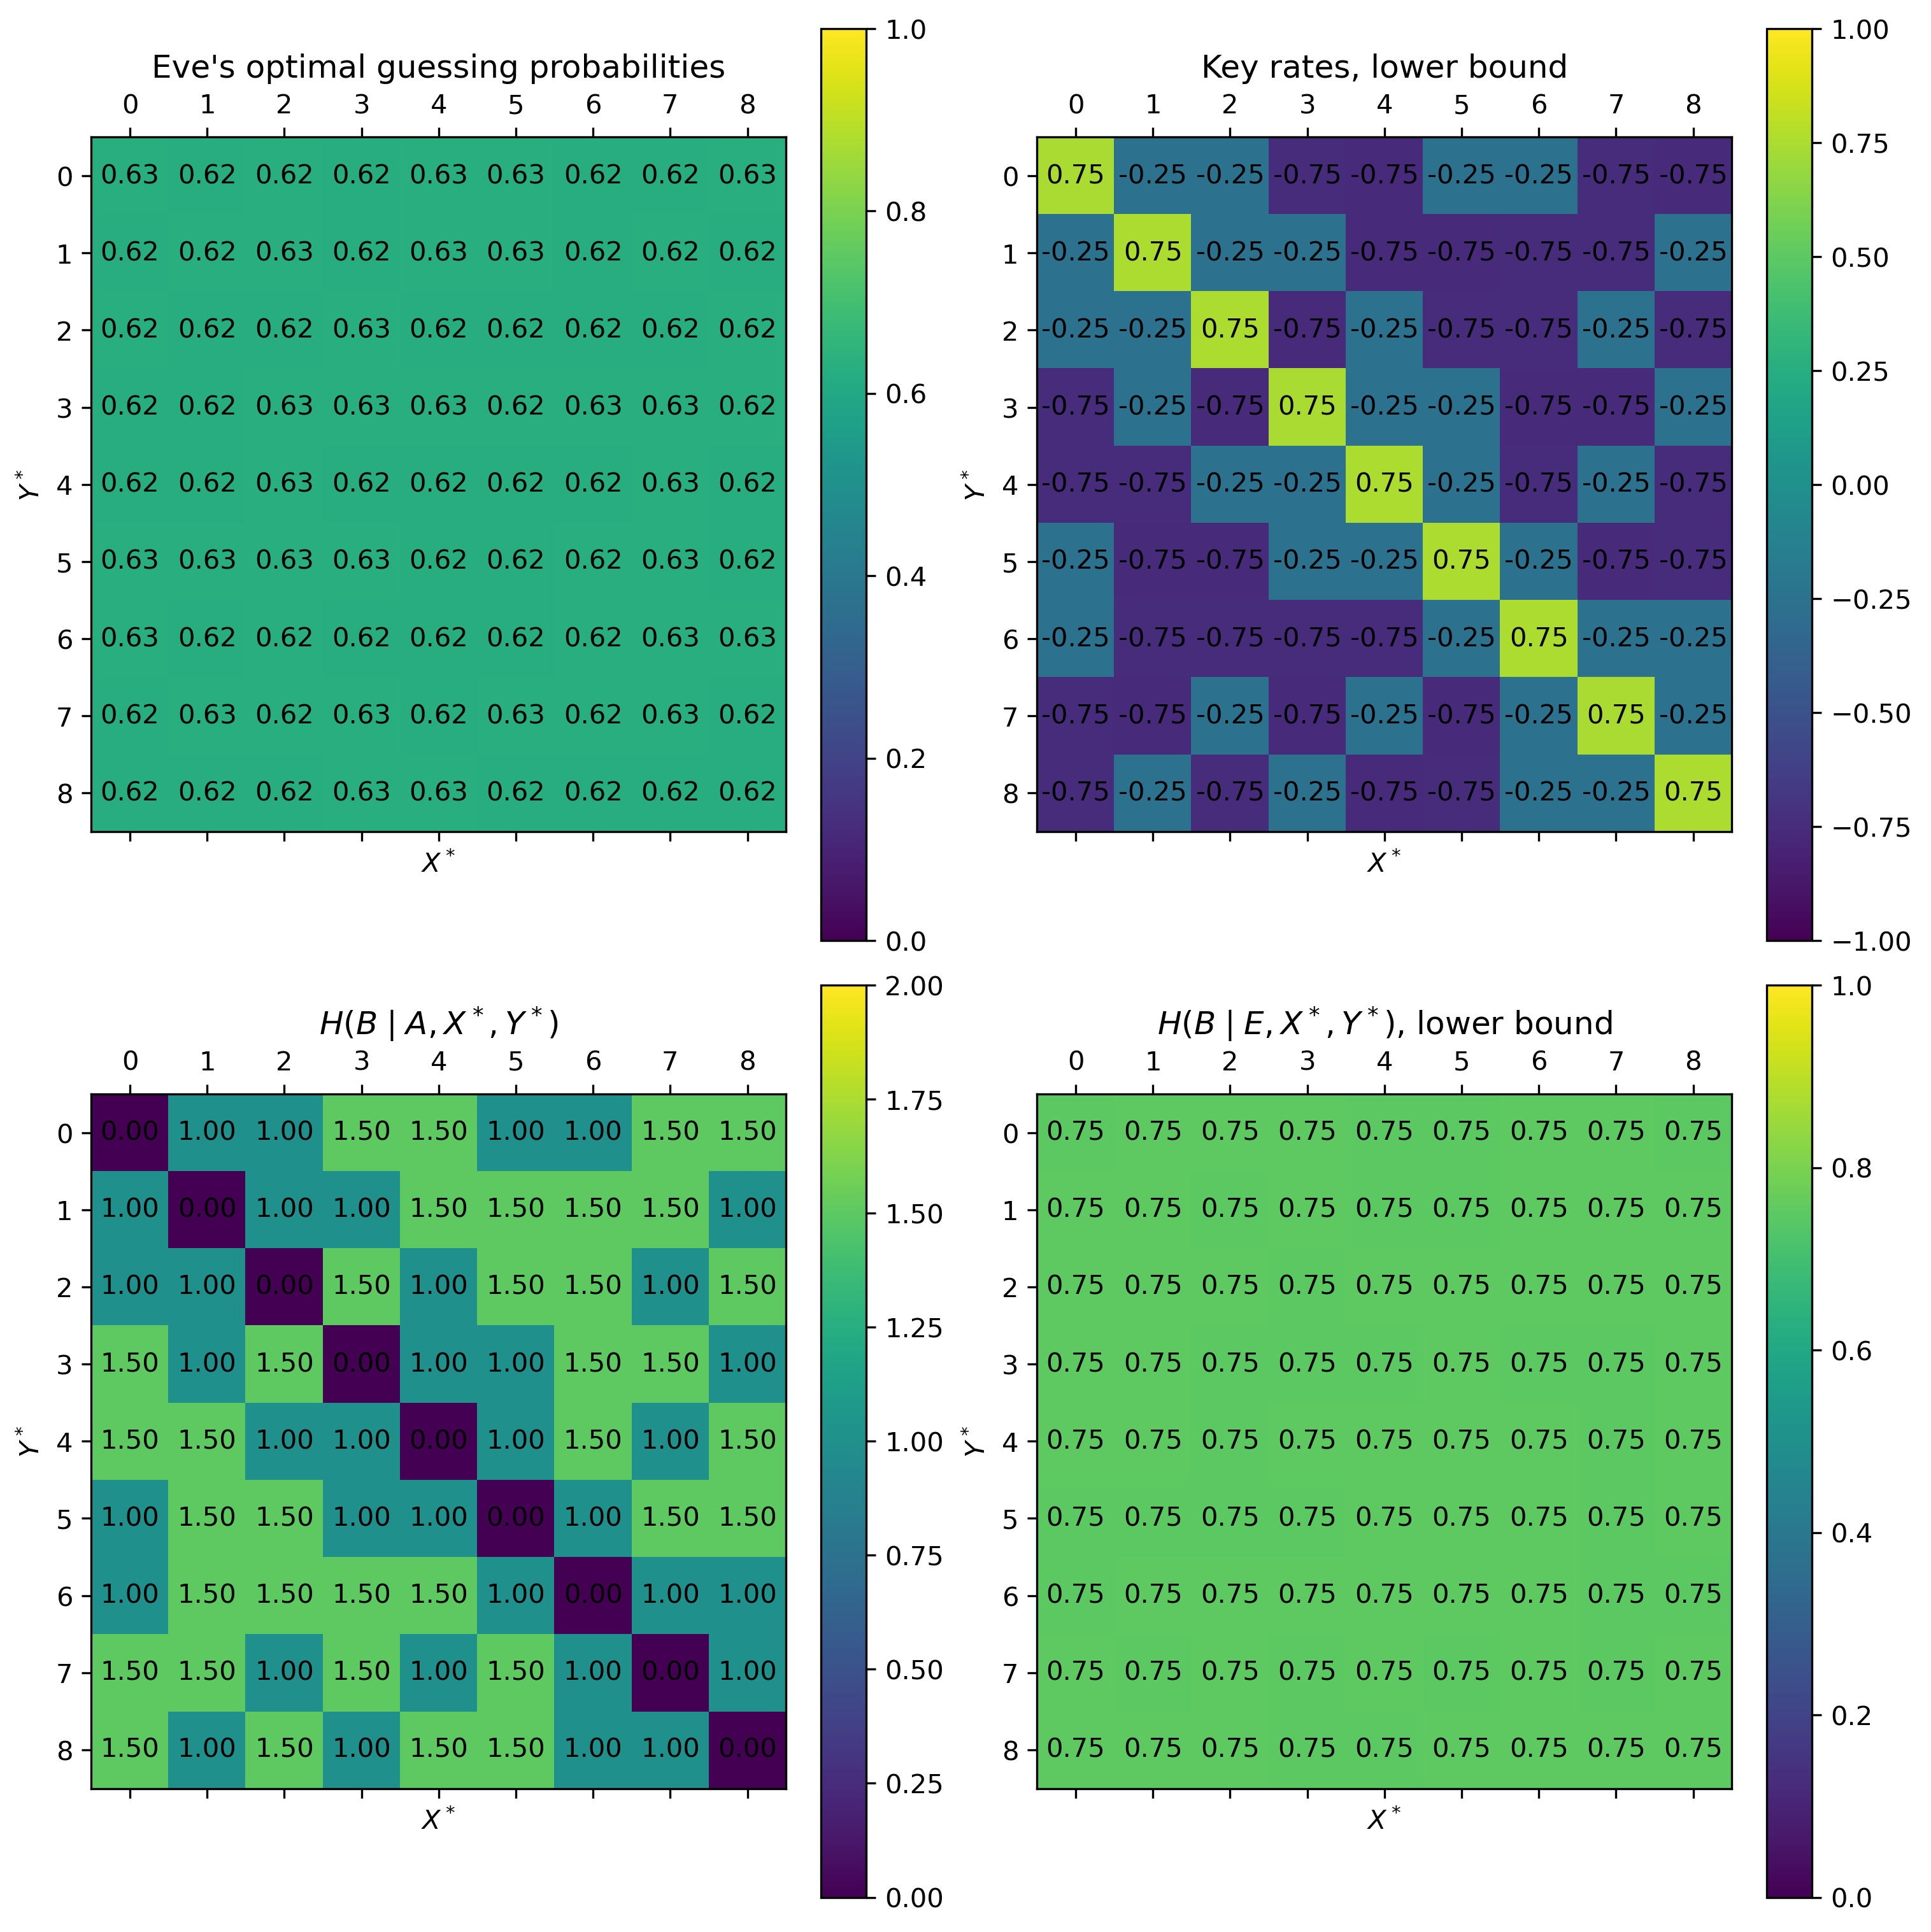

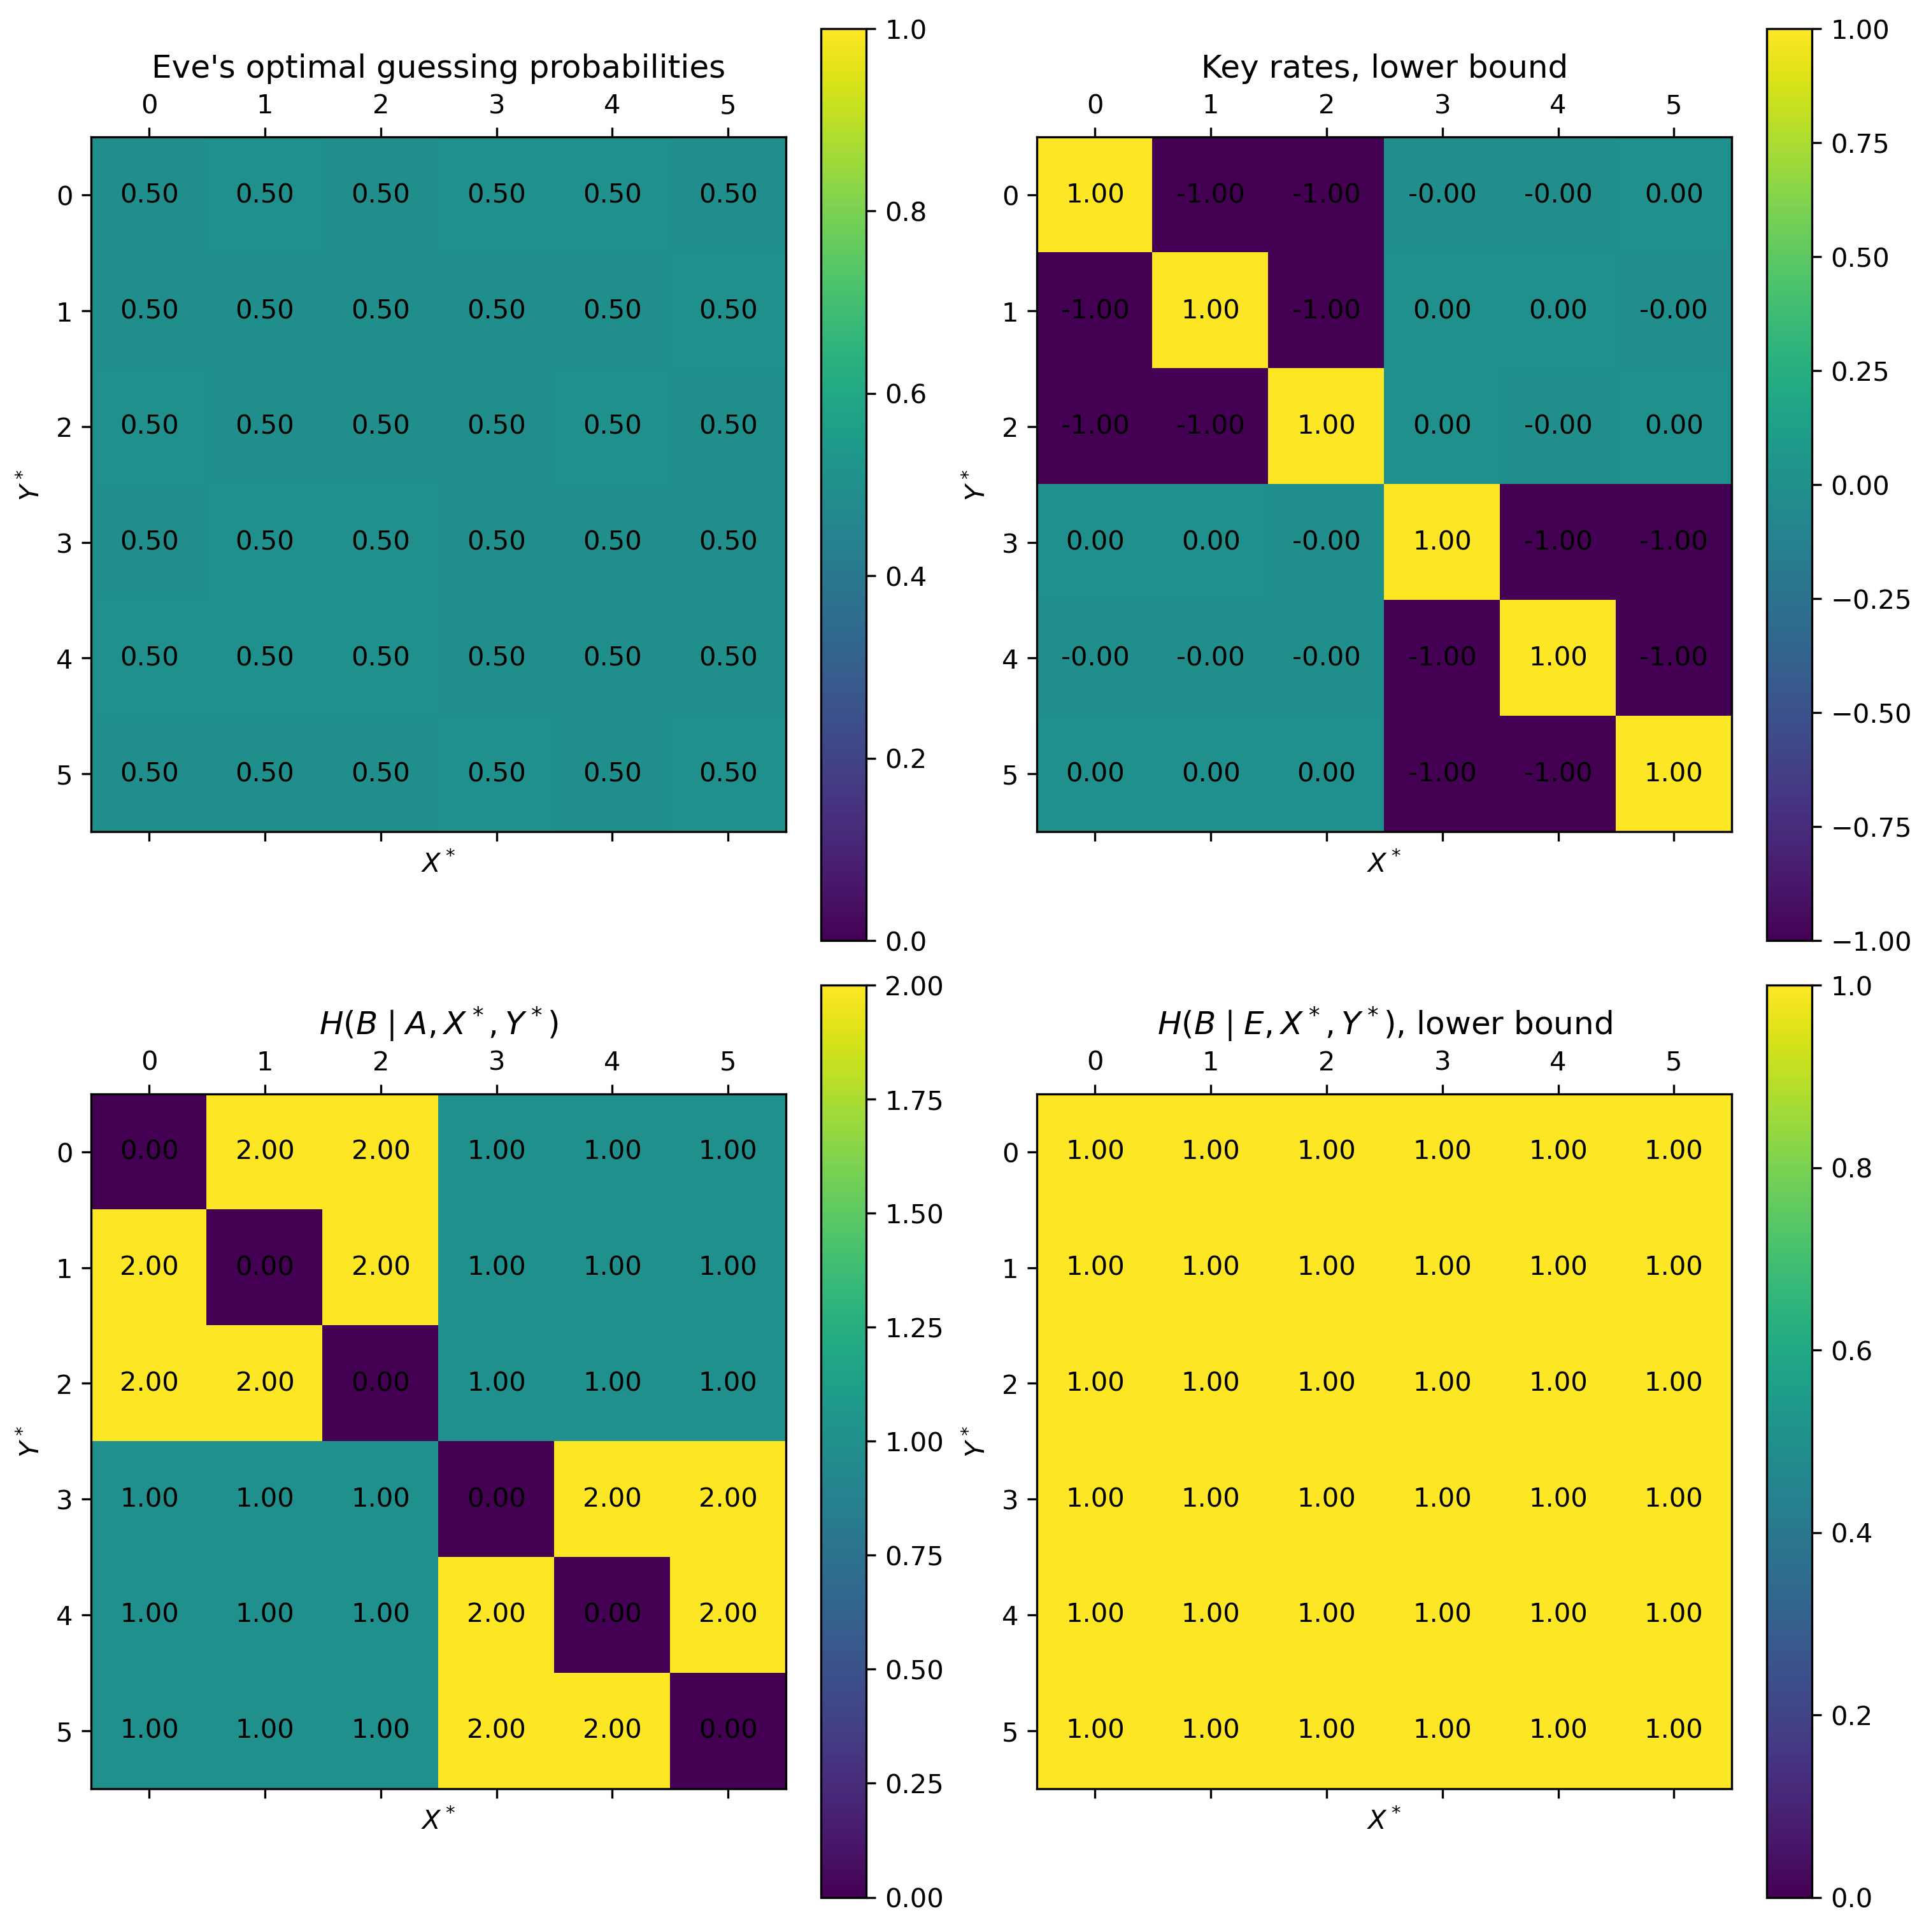

In [15]:
for i in range(5):
    makeplot(i)